In [0]:
# Training data
!wget --header="Host: ivc.ischool.utexas.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://vizwiz.org/tasks-and-datasets/image-captioning/" "https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip" -c -O 'train.zip'

In [0]:
# validation data
!wget --header="Host: ivc.ischool.utexas.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://vizwiz.org/tasks-and-datasets/image-captioning/" "https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip" -c -O 'val.zip'

In [0]:
from zipfile import ZipFile

with ZipFile('/content/train.zip') as z:
  z.extractall()

with ZipFile('/content/val.zip') as z:
  z.extractall()

with ZipFile('/content/annotations.zip') as z:
  z.extractall()

In [0]:
import os
import json
import re
import math
import numpy as np
import random
import time
import collections
from collections import defaultdict

import torch
import torch.nn as nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

from torchtext import vocab
from keras.preprocessing.sequence import pad_sequences

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Using TensorFlow backend.


In [0]:
class VizWizDataset(Dataset):
  """
     Custom class to create dataset of images and captions from json(annotation) file
    Args:
      annotation (str): path to the annotation of data
      size (int, int): size of the image to be resized
      path (str): path to the downloaded images
      ignore_rejected (bool): [default:True] to reject, captions with is_rejected flag as true, in dataset
      ignore_precanned (bool): [default:True] to reject, captions with is_precanned flag as true, in dataset
      text_detected (bool): [default:True] to accept captions only with 'text_detected' flag as true
    """

  def __init__(self, annotation, size, path, ignore_rejected = True, ignore_precanned = True, text_detected = True):
    self.PATH = path
    self.ignore_rejected = ignore_rejected
    self.ignore_precanned = ignore_precanned
    self.text_detected = text_detected

    # dict with img_id as key and value is list containing caption, 'is_precanned', 'is_rejected', 'text_detected'
    self.caps_dict = defaultdict(list)
    self.caps_dict_final = defaultdict(list)

    # list of images for which 'text_Detected' == True in image annotation
    self.imgs = []
    self.loadAnnotations(annotation)

    # transforms for image data
    self.tfms = transforms.Compose([transforms.Resize(size),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    
    # word counter dictionary with key as word and value as no. of word occurance
    self.count = collections.Counter()
    # word vocabulary
    self.word_vocab = None
    self.tokenize()
    
  def loadAnnotations(self, annotation):
    """
    function to load annotation data and update the captions of an image in dict
    and update the imgs list
    """
    # loading annotation file
    with open(annotation) as file:
      data = json.load(file)

    # update captions of corresponding image
    for annot in data['annotations']:
      if not ((self.ignore_rejected and annot['is_rejected']) or (self.ignore_precanned and annot['is_precanned'])):
        self.caps_dict[annot['image_id']].append(annot)

    # update imgs list
    for img in data['images']:
      if self.caps_dict[img['id']] and (img['text_detected'] and self.text_detected):
        self.imgs.append(img)

  def tokenize(self):
    """
    """
    PUNCTUATIONS = r'[!()\-[\]{};:"\,<>/?@#$%^&.*_~]'
    # special tokens
    START_TOKEN = '<sos>'
    END_TOKEN = '<eos>'
    PAD_TOKEN = '<pad>'
    UNK_TOKEN = '<unk>'

    # list of all captions in dataset for vocabulary
    text_corpus = []
    for key, value in self.caps_dict.items():
      for item in value:
        text = re.sub(PUNCTUATIONS, "", item['caption'])
        tokens = (START_TOKEN + ' ' + text.lower() + ' ' + END_TOKEN)
        self.caps_dict_final[str(key)].append(tokens)
        text_corpus.append(tokens.split())

    # counting words' frequency
    for seq in text_corpus:
      for word in seq:
        self.count[word]+=1

    # creating vocabulary of words
    self.word_vocab = vocab.Vocab(self.count,
                            max_size=7000,
                            min_freq=2,
                            specials=[PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN])
    
    
  def __len__(self):
    """Returns length of dataset"""
    # number of images
    return len(self.imgs)

  def __getitem__(self, idx):
    img_dict = self.imgs[idx]
    # image id
    id = img_dict['id']
    # load image from path
    img = Image.open(os.path.join(self.PATH, img_dict['file_name']))
    # applying transforms
    img = self.tfms(img)
    captions = [caption for caption in self.caps_dict_final[str(id)]]

    return img, captions

In [0]:
START_TOKEN = '<sos>'
END_TOKEN = '<eos>'
PAD_TOKEN = '<pad>'
UNK_TOKEN = '<unk>'

cnt = collections.Counter()
# vocabulary of all the words present in the train, valid captions
global global_vocab
global_vocab = vocab.Vocab(cnt,
                           max_size=10000,
                           min_freq=2,
                           specials=[PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN])

if torch.cuda.is_available():
  device='cuda'
else:
  device='cpu'

In [0]:
valid_ann = '/content/annotations/val.json'
size = (224, 224)
valid_path = '/content/val/'

train_ann = '/content/annotations/train.json'
train_path = '/content/train/'

In [0]:
def cap_collate_fn(batch):
  '''
  -> Custom collate function for torch DataLoader
    
    Returns batch images and captions
  '''
  imgs = [img for img,_ in batch]
  captions = [cap for _,cap in batch]
  # number of words in every sentence(caption) in a batch
  lens = []
  for item in captions:
    for cap in item:
      lens.append(len(cap.split(' ')))
  # max length of any sequence(caption) in the batch
  # max_len = np.percentile(lens, 100)
  max_len = max(lens)

  min_caps = min([len(caps) for _, caps in batch])
  capts = []
  # max_len = 128
  for idx in range(min_caps):
    items=[]
    for cap in captions:
      tokens = cap[idx].split(' ')
      tok_ids = [global_vocab.stoi[token] if global_vocab.stoi[token] else global_vocab.stoi['<unk>'] for token in tokens]
      items.append(tok_ids)
    capts.append(pad_sequences(items, maxlen=max_len, padding='post', truncating='post', value=0))
    # capts = pad_sequences(capts, maxlen=max_len, padding='post', truncating='post', value=0)
  return torch.stack(imgs), torch.LongTensor(capts)

In [0]:
bs = 5

train_d = VizWizDataset(train_ann, size, train_path)
valid_d = VizWizDataset(valid_ann, size, valid_path)

# update global vocab
global_vocab.extend(train_d.word_vocab)
global_vocab.extend(valid_d.word_vocab)

trainloader = DataLoader(train_d, batch_size= bs, shuffle=True, collate_fn=cap_collate_fn)
validloader = DataLoader(valid_d, batch_size=bs, shuffle=True, collate_fn = cap_collate_fn)

In [0]:
print('number of unique words in trainset captions: {}'.format(len(train_d.word_vocab)))
print('number of unique words in validset captions: {}'.format(len(valid_d.word_vocab)))

number of unique words in trainset captions: 7004
number of unique words in validset captions: 7004


In [0]:
print('number of unique words in global vocab: {}'.format(len(global_vocab)))

number of unique words in global vocab: 8796


In [0]:
# Number of validation and training samples
valid_d.__len__(), train_d.__len__()

(5010, 14684)

In [0]:
def denorm(x):
  """ """
  x = x.to('cpu')
  # converting to numpy
  # as dataloader appends an extra dimension of batch_size so squeeze
  x = x.detach().numpy().squeeze()
  # torch ToTensor changes the orientiation of Image data
  x = np.transpose(x, (1, 2, 0))
  # denormalizing
  x = x*np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406));
  x = x.clip(0, 1)
  return x

In [0]:
def show_batch(batch, row, column):
  """
    Args:
      batch : batch of data
      row, column : image representation
  """
  # images
  fig = plt.figure(figsize=(25,10))
  for i in range(len(batch[0])):
    ax = fig.add_subplot(row, column, i+1, xticks=[], yticks=[])
    plt.imshow(denorm(batch[0][i]))
    ax.set_title('img' + str(i+1))
  
  # captions
  for i in range(len(batch[1])):
    for idx, caps in enumerate(batch[1][i]):
      print('img'+str(idx+1), end=' ')
      for  cap in caps:
        if cap==0:
          break
        print(global_vocab.itos[cap], end=' ')
      print('')
    print('')

img1 <sos> a carton like container with a picture of citrus fruit on it sitting on a white surface <eos> 
img2 <sos> the right half of a white thermostat with a digital screen on it <eos> 
img3 <sos> a piece of paper with the text this app rocks <eos> 
img4 <sos> a <unk> <unk> cd that is black and has a gold eagle on the front <eos> 
img5 <sos> a white bottle of pills on a person's lap <eos> 

img1 <sos> a bottle showing the nutritional label with a stand mixer in the background <eos> 
img2 <sos> the temperature control dial for the house heating <eos> 
img3 <sos> a white paper has a message of this app rocks on it <eos> 
img4 <sos> some object is present in black color with a eagle image inside <eos> 
img5 <sos> side of a large white plastic bottle laying in a lap <eos> 

img1 <sos> a sliver of the side of a cardboard carton like for orange juice stands on a white counter with a silver bowl in the background <eos> 
img2 <sos> a white thermostat attached to a wall with a digital temper

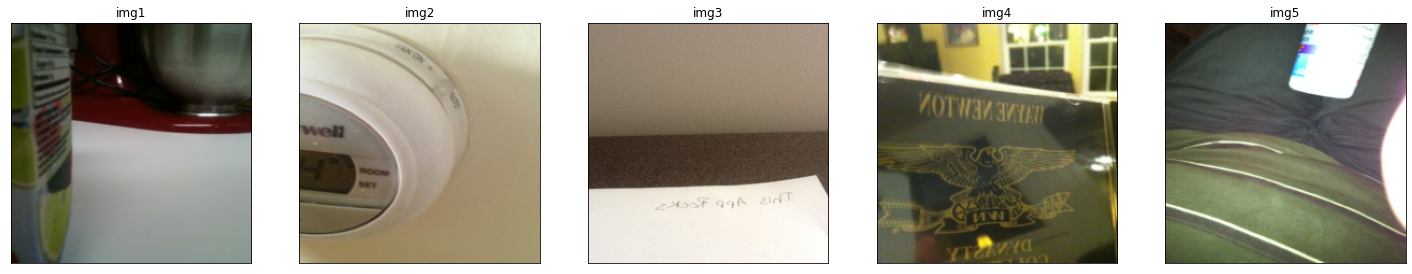

In [0]:
batch = iter(trainloader).next()
show_batch(batch, 2, 5)

In [0]:
class ResnetEncoder(nn.Module):
  def __init__(self, outsize=16):
    super(ResnetEncoder, self).__init__()
    # pretrained resnet model
    resnet = models.resnet34(pretrained = True)
    # removing classifier linear layer
    # as we require only the features of the images
    self.resnet = nn.Sequential(*list(resnet.children())[:-2])
    # for variable size input images -> fixed sized output
    self.avgPool = nn.AdaptiveAvgPool2d((outsize, outsize))

  def forward(self, x):
    x = self.resnet(x)
    # x -> bs x 2048 x 7 x 7
    x = F.relu(self.avgPool(x))
    # x -> bs x 2048 x outsize x outsize
    bs, feats= x.shape[0], x.shape[1]
    x = x.view(bs, feats, -1)
    return x.float()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [0]:
# class ImageEncoder(nn.Module):
#   def __init__(self):
#     super(ImageEncoder, self).__init__()
#     # pretrained vgg16 model
#     self.vgg = models.vgg16(pretrained = True)
#   def forward(self, x):
#     x = self.vgg(x)
#     # out dimension => bs x 1000
#     return x.long()

In [0]:
class PositionalEncoding(nn.Module):
  """
   -> Positional Encoding ...

    Args:
      dim (int): dimension of embedding
  """
  def __init__(self, dim, max_len=250):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, dim)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    freq = 1/10000**(torch.arange(0., dim, 2.)/dim)
    pe[:, 0::2] = torch.sin(position*freq)
    pe[:, 1::2] = torch.cos(position*freq)
    self.register_buffer('pe', pe)
    
  def forward(self, sz):
    return self.pe[:sz, :]

In [0]:
class TransformerEmbedding(nn.Module):
  """
    dim : dimension of embedding
    vocab_sz : size of vocabulary
    drop_p : dropout probability
    pretrained : load the weights of pretrained embedding
  """
  def __init__(self, vocab_sz, d_model, device, drop_p = 0, pretrained=False):
    self.device=device
    super(TransformerEmbedding, self).__init__()
    self.vocab_sz = vocab_sz
    self.embed = nn.Embedding(vocab_sz, d_model)
    self.pos_enc = PositionalEncoding(d_model)
    self.dropout = nn.Dropout(drop_p)
    
  # TODO: load pretrained embedding
  # def init_embed_weight(self):
  #   pass
  
  def forward(self, x):
    x = x.to(self.device)
    embed = self.embed(x)*math.sqrt(self.vocab_sz) + self.pos_enc(x.shape[1])
    # embed = self.embed(x) + self.pos_enc
    # embed = self.embed(x)
    return self.dropout(embed)

In [0]:
class TransformerModel(nn.Module):
  def __init__(self, enc_vocab_sz, dec_vocab_sz, d_model, device, enc_emb_drop = 0.0,
               n_enc_layers=6, n_dec_layers=6, nheads=8):
    super(TransformerModel, self).__init__()

    self.pad_idx=1
    # input embedding
    # self.enc_embed = TransformerEmbedding(vocab_sz=enc_vocab_sz, d_model=d_model, drop_p=enc_emb_drop, device=device)
    # output embeddding
    self.dec_embed = TransformerEmbedding(vocab_sz=dec_vocab_sz, d_model=d_model, drop_p=0.0, device=device)
    
    # transformer encoder layer
    enc_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                           nhead=nheads,
                                           dim_feedforward=2048)
    # transformer decoder layer
    dec_layer = nn.TransformerDecoderLayer(d_model=d_model,
                                           nhead=nheads,
                                           dim_feedforward=1024)

    # transformer encoder
    self.Transformer_enc = nn.TransformerEncoder(enc_layer, n_enc_layers)
    # transformer Decoder
    self.Transformer_dec = nn.TransformerDecoder(dec_layer, n_dec_layers)

    # final linear layer
    self.linear_out = nn.Linear(d_model, dec_vocab_sz)
    # softmax layer
    self.softmax = nn.Softmax(dim=-1)

  def gen_mask(self, szx, szy):
    """ 
    -> generate mask for attention layers
    -> for square mask szx == szy == seq_length
    -> for key_padding mask szx == batch_size and szy == seq_length

      for key_padding_mask, function assumes the pad_idx in vocab is zero.

      Args:
        szx : num of rows
        szy : num of columns

      Returns:
        mask (square mask / key_padding mask)
    """
    mask = (torch.triu(torch.ones(szx, szy)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def forward(self, inp, target):    
    # enc_embed_out = self.enc_embed(inp)
    enc_embed_out = inp
    enc_embed_out = enc_embed_out.permute(1,0,2)
    # enc_embed_out dim => (seq_length(512) x batch_size x num_features(d_model))
    # print(enc_embed_out.shape)

    dec_embed_out = self.dec_embed(target)
    dec_embed_out = dec_embed_out.permute(1, 0, 2)
    # dec_embed_out dim => (seq_length x batch_size x num_features)
    # print(dec_embed_out.shape)

    enc_out = self.Transformer_enc(src = enc_embed_out)
    # print(enc_out.shape)

    tgt_mask = self.gen_mask(dec_embed_out.shape[0], dec_embed_out.shape[0])
    tgt_mask = tgt_mask.to(device)
    # tgt_key_padding_mask = self.get_key_padding_mask

    dec_out = self.Transformer_dec(tgt=dec_embed_out,
                                   memory=enc_out,
                                   tgt_mask= tgt_mask,
                                   tgt_key_padding_mask=None)
    # output shape => seq_length x batch_size x num_features
    dec_out = dec_out.permute(1, 0, 2)
    # print(dec_out.shape)

    out = self.linear_out(dec_out)
    # return out
    # return self.softmax(out)
    return out

In [0]:
d_model = 256                       # dimension of embedding
enc_vocab_sz = len(global_vocab)    # vocab size of encoder embedding
dec_vocab_sz = len(global_vocab)    # vocab size of decoder embedding

In [0]:
# for i in range(128):
#   " ".join([global_vocab.itos[torch.argmax(out[0][i])] for i in range(128)])

In [0]:
# Model
imgEncoder = ResnetEncoder().to(device)
transformerModel = TransformerModel(enc_vocab_sz=enc_vocab_sz,
                                    dec_vocab_sz=dec_vocab_sz,
                                    d_model=d_model,
                                    device=device,
                                    enc_emb_drop=0.1).to(device)

# for loss calculation, we'll not consider '<pad>' values in target
criterion = nn.CrossEntropyLoss(ignore_index=global_vocab.stoi['<pad>'],
                                reduction = 'sum')

# total parameters in the model
params = list(imgEncoder.parameters())+list(transformerModel.parameters())
optimizer = optim.Adam(params, lr = 0.003, betas=(0.9, 0.98), eps=1e-9)   # optimizer

In [0]:
def seed_all(seed_value):
    """
     -> Function to random seed all the gpu and cpu variables for 
        regeneration of same results at the time of testing as they were at training
    """
    random.seed(seed_value) # Python
    torch.manual_seed(seed_value) # cpu vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value) # gpu variables

In [0]:
a=(sum(p.numel() for p in imgEncoder.parameters() if p.requires_grad))
b=(sum(p.numel() for p in transformerModel.parameters() if p.requires_grad))
print(f'Total Number of Trainable parameters in complete model(encoder + transformerModel): {a+b}')

Total Number of Trainable parameters in complete model(encoder + transformerModel): 40008092


In [0]:
def printTime(clk, prc):
  """
  function to convert seconds time into proper format
  Args:
    clk: time in seconds
    prc: process type(train/valid)
  """
  print(f'{prc} time: {time.strftime("%H:%M:%S",time.gmtime(clk))}')

In [0]:
EPOCHS = 5
clip = 1
best_valid_loss = float('inf')
seed=49

seed_all(seed)

trn_loss=[]
vld_loss=[]

mbar = tqdm(range(EPOCHS), total = EPOCHS, leave=False)
for epoch in mbar:
  print('******** Epoch - {:2}********'.format(epoch+1))
  ##################################
  ##           Training           ##
  ##################################
  start_time = time.time()
  imgEncoder.train()
  transformerModel.train()
  train_loss=0.

  pbar = tqdm(enumerate(trainloader), total=len(trainloader), leave = False)
  for idx, batch in pbar:
    pbar.set_description('Training...')

    imgs = batch[0].to(device)        # images
    captions = batch[1].to(device)    # captions
    optimizer.zero_grad()

    b_loss=0   # batch_loss

    # image features
    img_feats = imgEncoder(imgs)
    # every image has multiple captions
    # So training for each caption seperately
    cap_loss=0
    for i in range(len(captions)):
      # feed the captions(target), img_feats(src) into transformer model
      output = transformerModel(inp = img_feats,
                                target = captions[i])
      
      preds = output.view(-1, output.shape[-1])
      target = captions[i].contiguous().view(-1)
      loss = criterion(input=preds, target=target)
      cap_loss+=loss

    # num of non zero tokens in all captions
    num_tok = torch.sum(captions!=0)
    cap_loss/=num_tok.item()
    b_loss+=cap_loss
    # clipping gradients to prevent from gradient exploding problem
    # torch.nn.utils.clip_grad_norm_(transformerModel.parameters(), clip)
    # torch.nn.utils.clip_grad_norm_(imgEncoder.parameters(), clip)

    # calculating gradients
    cap_loss.backward()
    # updating model parameters
    # TODO: how to update paramters of two models
    optimizer.step()

    if idx%1000 == 0:
      trn_loss.append(cap_loss.item())
      print(f'trn_loss: {b_loss:.5f}')

  train_loss = b_loss/len(trainloader)
  train_time = time.time() - start_time

  # reset time for validation
  start_time = time.time()
  ################################
  ##         Validation         ##
  ################################
  imgEncoder.eval()
  transformerModel.eval()
  valid_loss = 0.
  with torch.no_grad():
    pbar = tqdm(enumerate(validloader), total=len(validloader), leave=False)
    for idx, batch in pbar:
      pbar.set_description('Validation...')
      imgs = batch[0].to(device)        # images
      captions = batch[1].to(device)    # captions

      b_loss=0
      cap_loss=0
      # image features
      img_feats = imgEncoder(imgs)
      for i in range(len(captions)):
        output = transformerModel(inp=img_feats,
                                  target=captions[i])
        
        preds = output.view(-1, output.shape[-1])
        target = captions[i].contiguous().view(-1)
        loss = criterion(input=preds, target=target)
        cap_loss+=loss

      num_tokens = torch.sum(captions!=0)
      cap_loss/=num_tokens.item()
      b_loss+=cap_loss

    valid_loss = b_loss/(len(validloader))
    vld_loss.append(valid_loss.item())

  # eval time
  eval_time = time.time()-start_time

  # save best model
  if valid_loss.item() < best_valid_loss:
    best_valid_loss = valid_loss.item()
  
  print('Training Loss: {:.4f} | Validation Loss: {:.4f}'.format(train_loss, valid_loss))
  printTime(train_time, 'Training')
  printTime(eval_time, 'Validation')

******** Epoch -  1********


trn_loss: 9.04334
trn_loss: 5.25759
trn_loss: 5.14115


Training Loss: 0.0018 | Validation Loss: 0.0112
Training time: 00:49:08
Validation time: 00:07:38
******** Epoch -  2********


trn_loss: 4.81425
trn_loss: 4.98185
trn_loss: 4.85432


Training Loss: 0.0016 | Validation Loss: 0.0093
Training time: 00:48:58
Validation time: 00:07:34
******** Epoch -  3********


trn_loss: 5.05886


In [0]:
def calcuate_bleu(preds, target):
  """ """
  # using greedy method to get tokens
  preds = torch.argmax(preds, dim=-1)

  # predicted tokens
  pred_seqs=[]
  for seq in preds:
    tokens=[]
    for id in seq:
      # checking the seq upto pad of eos token
      if id == 0 or id == 2:
        break
      tokens.append(global_vocab.itos[id])
    pred_seqs.append(tokens)

  # reference(target) tokens
  tgt_seqs=[]
  for seq in target:
    tokens = []
    for id in seq:
      if id==0 or id==2:
        break
        tokens.append(global_vocab.itos[id])
      tgt_seq.append(tokens)
  
  bleu_scr = torchtext.data.metrics.bleu_score(pred_seqs, tgt_seqs)
  return bleu_scr

In [0]:
from torchtext.data.metrics import bleu_score

ImportError: ignored

In [0]:
print(torch.__version__)

1.5.0+cu101


In [0]:
print(torchvision.__version__)

0.6.0+cu101
